# 模型选择、欠拟合和过拟合
终极目标是模型的泛化，能在从来没有见过的数据上也有很好的效果。

## 训练误差和泛化误差
1. 训练误差(training error)：指的是，模型在训练数据集上计算得到的误差。
2. 泛化误差(generalization error)：指的是模型应用在同样从原始样本的分布中抽取的无限多样本数据时，模型误差的期望。

## 验证集
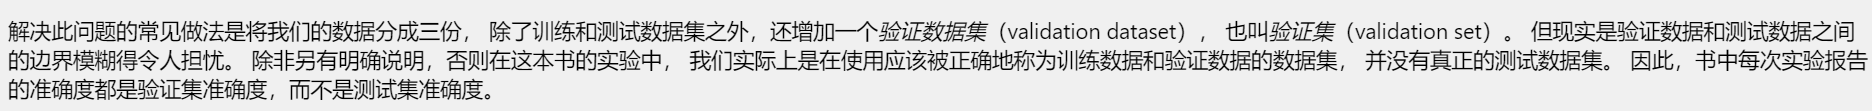

## K折交叉验证
原始训练数据被分成$K$个不重叠的子集。然后执行$K$次模型训练和验证，每次在$K-1$个子集上进行训练，并在剩余的一个自己(在该轮中没有用于训练的子集)上进行验证。最后，通过对$K$次实验的结果取平均来估计训练和验证误差。

## 欠拟合还是过拟合？
1. 欠拟合：模型的复杂度不够，不能很好地拟合训练数据。训练误差和验证误差都很严重，但他们之间仅有一点差距。
2. 过拟合：模型的复杂度过高，拟合了训练数据中的噪声。训练误差很小，但验证误差很大。

是否过拟合或是欠拟合可能取决于模型复杂性和可用训练数据集的大小。下面就这两点进行讨论。

### 模型复杂性
提供一个多项式的例子。给定由单个特征$x$和对应实数标签$y$组成的训练数据，我们试图找到下面的$d$阶多项式来估计标签$y$。
$$
y = \sum_{i = 0}^{d} x^i w_i
$$

特征是由$x$的幂给出，权重是$w_i$给出，偏置是$w_0$给出，损失函数是平方误差。

高阶多项式的参数较多，魔性函数的选择范围较广。因此在固定训练数据集的情况下，高阶多项式函数相对于低阶多项式的训练误差应该始终更低（最坏也是相等）。事实上，当数据样本包含了$x$的不同值时，函数阶数等于数据样本数量的多项式函数可以完美拟合训练集。如下图，直观的描述了多项式的阶数和欠拟合与过拟合之间的关系。

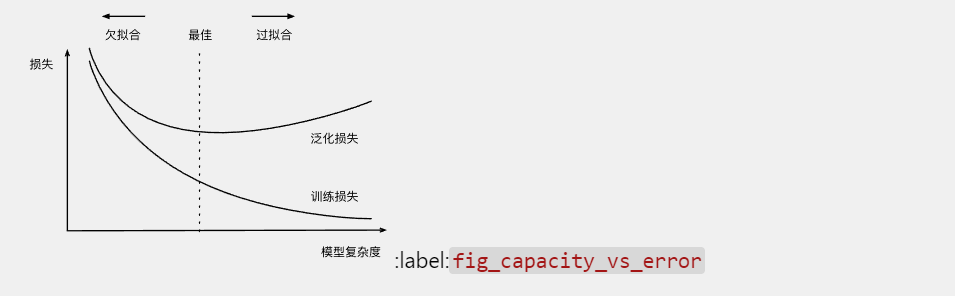

### 数据集的大小
训练样本越少，就越有可能（且更为严重）过拟合。随着训练数据量的增加，泛化误差通常会减小。此外，一般来说，更多的数据不会有什么坏处。对于固定的任务和数据分布，模型复杂性和数据大小之间通常存在关系。给出更多的数据，我们可能会尝试拟合一个更复杂的模型。能够拟合更复杂的模型可能是有益的。如果没有足够的数据，简单的模型可能更有用。对于许多任务，深度学习只有在有数千个训练样本时才优于线性模式。从一定程度上来说，深度学习目前的生机要归功于廉价存储、互联设备以及数字化经济带来的海量数据集。

## 多项式回归

In [1]:
import math
import numpy as np
import torch 
from torch import nn
from d2l import torch as d2l

### 生成数据集
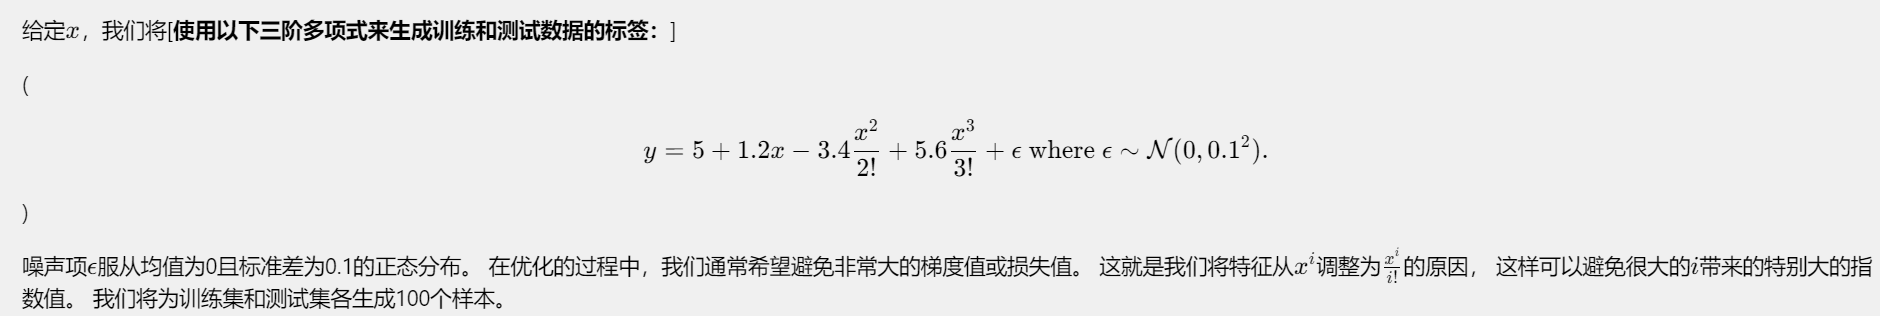

In [2]:
max_degree = 20 # 多项式的最大阶数
n_train, n_test = 100, 100 # 训练和测试数据集大小
true_w = np.zeros(max_degree) # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n) = (n-1)!
# labels的维度：(n_train + n_test, )
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)


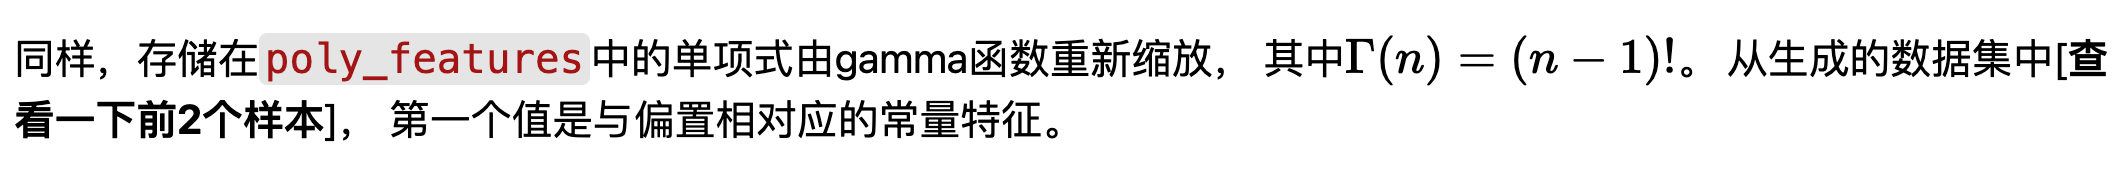

In [3]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
                torch.float32) for x in [true_w, features, poly_features, labels]]

In [4]:
features[:2], poly_features[:2, :], labels[:2]

(tensor([[0.0348],
         [0.3283]]),
 tensor([[1.0000e+00, 3.4807e-02, 6.0575e-04, 7.0280e-06, 6.1155e-08, 4.2572e-10,
          2.4696e-12, 1.2280e-14, 5.3427e-17, 2.0662e-19, 7.1919e-22, 2.2757e-24,
          6.6007e-27, 1.7673e-29, 4.3938e-32, 1.0195e-34, 2.2179e-37, 4.5411e-40,
          8.7861e-43, 1.4013e-45],
         [1.0000e+00, 3.2831e-01, 5.3893e-02, 5.8978e-03, 4.8407e-04, 3.1785e-05,
          1.7392e-06, 8.1570e-08, 3.3475e-09, 1.2211e-10, 4.0090e-12, 1.1965e-13,
          3.2736e-15, 8.2672e-17, 1.9387e-18, 4.2433e-20, 8.7068e-22, 1.6815e-23,
          3.0669e-25, 5.2994e-27]]),
 tensor([4.9391, 5.2567]))

### 对模型进行训练和测试

定义训练函数

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduce='none')
    input_shape = train_features.shape[-1]
    # 不用设置偏置，因为我们在多项式中已经实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_features.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or  (epoch+1) % 20 == 0:
            animator.add(epoch+1, (d2l.evaluate_loss(net, train_iter, loss),
                                   d2l.evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

### 三阶多项式拟合（正常）
真实值是$w = [5, 1.2, -3.4, 5.6]$

weight: [[ 4.9847836  1.1929512 -3.4002037  5.6011925]]


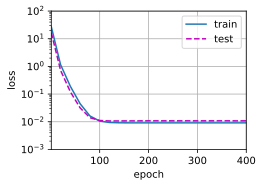

In [6]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

### 线性函数拟合[欠拟合]

weight: [[3.4598942 4.740769 ]]


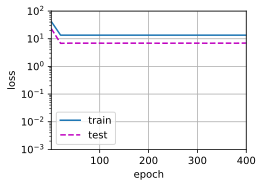

In [7]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

### 高阶多项式函数拟合[过拟合]

weight: [[ 4.9548435   1.3011016  -3.2519884   5.166588   -0.34675583  0.89267623
   0.21006417  0.08988844 -0.10148991  0.02963435 -0.20930874 -0.14092319
   0.06092003 -0.2181516  -0.17873266 -0.12984356 -0.09809499 -0.12974799
  -0.03182085  0.1588374 ]]


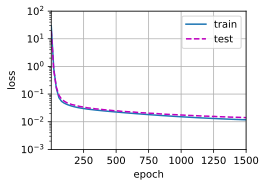

In [8]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)